# Experiments with CIFAR-100 Dataset and Original MoE

The experiments in this notebook include training the original MoE models as follows:

1. original MoE without regularization.
2. original MoE with $L_{importance}$ regularization.
3. original MoE with $L_s$ regularization.
4. train a single model.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cpu


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of intuitive task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cpu


## Load CIFAR100 dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'
results_path = '../results'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)    

In [7]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [8]:
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
cifar100_testset, cifar100_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ))

In [9]:
num_classes = 100

In [10]:
trainsize = 50000
testsize = 10000

In [11]:
batch_size = 256

In [12]:
cifar100_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)
cifar100_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=True)

In [13]:
import csv
with open(os.path.join('./data','cifar100_class_names.txt'),'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    classes_cifar100 = []
    for row in csvreader:
        if row:
            classes_cifar100.append(row[1])

classes_cifar100     

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'cra',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tige

In [14]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg)
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

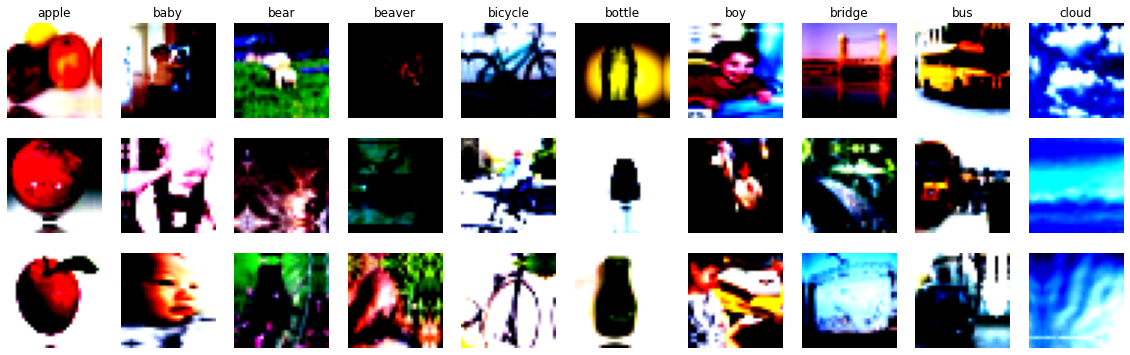

In [15]:
# get some random training images
dataiter = iter(cifar100_trainloader)
images, labels = dataiter.next()

images_to_plot = []
count = 0
selected_labels = []
for i in range(100):
    if count == 10:
        break
    index = np.where(labels==i)[0]
    if len(index) >= 3:
        selected_labels.append(i)
        images_to_plot.append(images[index[0:3],:,:])
        count += 1
    
selected_labels = [classes_cifar100[i] for i in selected_labels]
images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)
plot_colour_images(images_to_plot, nrows=3, ncols=10,thefigsize=(20,6), titles=selected_labels)

## Define expert and gate networks

In [16]:
# Convolutional network with 4 convultional layers and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,1024)
        self.fc2 = nn.Linear(1024, 256)
        
        self.out = nn.Linear(in_features=256, out_features=num_classes)
                        
    def forward(self, x):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))    
    
        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))

        x = x.reshape(-1, self.filters*8*2*2)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)

        return x
    

In [40]:
# Convolutional network with 4 convultional layers and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        
        self.out = nn.Linear(in_features=256, out_features=num_experts)
        
    def forward(self, x, T=1.0, y=None):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
                
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        x = F.softmax(x/T, dim=1)
        return x


In [41]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [42]:
# Convolutional network with 4 convultionals layers and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(single_model, self).__init__()
        filter_size = 3
        self.filters = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,1024)
        self.fc2 = nn.Linear(1024, 256)
        
        self.out = nn.Linear(in_features=256, out_features=num_classes)
                        
    def forward(self, x):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))    
    
        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
                    
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)
                
        return x

## Initialize configurations and helper functions

In [21]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train original model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [22]:
from itertools import product

def train_original_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                         w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20):

    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, 
                                                                         w_sample_sim_same_range,  w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        
        for run in range(1, runs+1):
            
            print('Run:', run)
            
            n_run_models_1 = []
            
            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)

                gate_model = gate_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model,device=device).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False, weight_decay=1e-3)
                
               
                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, w_sample_sim_same = w_sample_sim_same, 
                                       w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}                


            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []


### Function to train the single model

In [23]:
def train_single_model(model_name, trainloader, testloader, num_classes, num_epochs, runs):
    
    loss_criterion = cross_entropy_loss()
    
    n_runs = {'models':[], 'history':[]}
    
    for run in range(1, runs+1):
        
        print('Run', run)
        
        model = single_model(num_classes).to(device)
        history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
        optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=False, weight_decay=1e-3)
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                optimizer.zero_grad()
                loss = loss_criterion(outputs, None, None, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                outputs = model(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            test_running_accuracy = 0.0
            test_num_batches = 0
            
            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)
                test_outputs = model(test_inputs)              
                test_running_accuracy += accuracy(test_outputs, test_labels)
                test_num_batches += 1
                
            loss = (running_loss/num_batches)
            train_accuracy = (train_running_accuracy/num_batches)
            test_accuracy = (test_running_accuracy/test_num_batches)
            
            history['loss'].append(loss)
            history['accuracy'].append(train_accuracy.item())
            history['val_accuracy'].append(test_accuracy.item())
            
            print('epoch %d' % epoch,
                  'training loss %.2f' % loss,
                   ', training accuracy %.2f' % train_accuracy,
                   ', test accuracy %.2f' % test_accuracy
                   )
            
        plot_file = generate_plot_file(model_name, specific=str(num_classes)+'_models.pt')
        if os.path.exists(os.path.join(model_path, plot_file)):
            n_runs = torch.load(open(os.path.join(model_path, plot_file),'rb'))
        n_runs['models'].append(model)
        n_runs['history'].append(history)        
        torch.save(n_runs, open(os.path.join(model_path, plot_file),'wb'))
        
        n_runs = {'models':[], 'history':[]}

## Experiments

### Experiment 1: Original MoE model trained without gate regularization

In [43]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar100_without_reg'

In [44]:
total_experts = 20

In [45]:
num_epochs = 40

In [46]:
runs = 1

In [47]:
temps = [[1.0]*num_epochs]

In [ ]:
train_original_model(model_1, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 2: Original MoE model trained with $L_{importance}$ regularization

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar100_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 40

In [50]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [ ]:
temps = [[1]*num_epochs]

In [ ]:
runs = 5

In [ ]:
train_original_model(model_2, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     w_importance_range=w_importance_range, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

### Experiment 3: Original MoE model trained with sample similarity regularization, $L_s$

In [ ]:
model_3 = 'cifar100_with_reg'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 40

In [ ]:
temps = [[1]*num_epochs]

In [49]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3]
w_sample_sim_diff_range = [1e-7,1e-6,1e-5, 1e-4, 1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-05, 0.0001, 0.001]
w_sample_sim_diff_range =  [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [ ]:
runs = 5

In [ ]:
train_original_model(model_3, cifar100_trainloader, cifar100_testloader, runs, temps=temps,
                     w_sample_sim_same_range=w_sample_sim_same_range, 
                     w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

### Experiment 4: Training the single model

In [35]:
model_4 = 'cifar100_single_model'

In [36]:
num_epochs = 40

In [37]:
runs = 5

In [38]:
train_single_model(model_4, cifar100_trainloader, cifar100_testloader, num_classes, num_epochs, runs)

Run 1
epoch 0 training loss 4.09 , training accuracy 0.07 , test accuracy 0.12
epoch 1 training loss 3.56 , training accuracy 0.15 , test accuracy 0.18
epoch 2 training loss 3.35 , training accuracy 0.19 , test accuracy 0.21
epoch 3 training loss 3.20 , training accuracy 0.22 , test accuracy 0.23
epoch 4 training loss 3.10 , training accuracy 0.24 , test accuracy 0.26
epoch 5 training loss 3.00 , training accuracy 0.26 , test accuracy 0.27
epoch 6 training loss 2.93 , training accuracy 0.27 , test accuracy 0.29
epoch 7 training loss 2.86 , training accuracy 0.28 , test accuracy 0.31
epoch 8 training loss 2.80 , training accuracy 0.30 , test accuracy 0.31
epoch 9 training loss 2.75 , training accuracy 0.31 , test accuracy 0.32
epoch 10 training loss 2.70 , training accuracy 0.32 , test accuracy 0.33
epoch 11 training loss 2.67 , training accuracy 0.32 , test accuracy 0.33
epoch 12 training loss 2.63 , training accuracy 0.33 , test accuracy 0.34
epoch 13 training loss 2.61 , training acc

## Results

### Collect the train error, test error for the trained single models and store in the '../results/cifar100_results.csv' file.

In [24]:
pre_trained_model_path = '../models'

In [ ]:
results_file = 'cifar100_results.csv'

In [ ]:
import csv

m = 'cifar100_single_model'
plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')
models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
filename = os.path.join(results_path, results_file)
if os.path.exists(filename):
    p = 'a'
else:
    p = 'w'
        
header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
with open(filename, p) as f:
    writer = csv.writer(f)        

    if p == 'w':            
        writer.writerow(header)
    for i, model in enumerate(models['models']):
        data = ['']*5
        data[0] = m+'_'+str(i)
        running_test_accuracy = 0.0
        num_batches = 0
        train_error = 1-models['history'][i]['accuracy'][-1]
        data[1] = train_error
        for test_inputs, test_labels in cifar100_testloader:
            test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
            outputs = model(test_inputs)
            running_test_accuracy += accuracy(outputs, test_labels)
            num_batches += 1
        test_error = 1-(running_test_accuracy/num_batches)
        data[2] = test_error.item()
        
        writer.writerow(data)
